### Loading libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR

import seaborn as sns

from tqdm.notebook import tqdm
from scipy.signal import correlate
from statsmodels.graphics.tsaplots import plot_acf
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

In [105]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Концепции альф

1. Набор LSTM для каждого инструмента, которые определяет, будет ли return положительным или нет
2. LSTM для портфеля

### Loading data

In [106]:
close = pd.read_csv('close.csv', index_col='time')
close.index = pd.to_datetime(close.index)
close.ffill(inplace=True)

open = pd.read_csv('open.csv', index_col='time')
open.index = pd.to_datetime(open.index)
open.ffill(inplace=True)

high = pd.read_csv('high.csv', index_col='time')
high.index = pd.to_datetime(high.index)
high.ffill(inplace=True)

low = pd.read_csv('low.csv', index_col='time')
low.index = pd.to_datetime(low.index)
low.ffill(inplace=True)

value = pd.read_csv('value.csv', index_col='time')
value.index = pd.to_datetime(value.index)
value.ffill(inplace=True)

volume = pd.read_csv('volume.csv', index_col='time')
volume.index = pd.to_datetime(volume.index)
volume.ffill(inplace=True)

In [107]:
# close = pd.read_csv('data/hour/close.csv', index_col='Time')
# opens = pd.read_csv('data/hour/opens.csv', index_col='Time')
# high = pd.read_csv('data/hour/high.csv', index_col='Time')
# low = pd.read_csv('data/hour/low.csv', index_col='Time')
# volume = pd.read_csv('data/hour/volume.csv', index_col='Time')

# close_h = pd.read_csv('data/half/close_h.csv', index_col='Time')
# opens_h = pd.read_csv('data/half/open_h.csv', index_col='Time')
# high_h = pd.read_csv('data/half/high_h.csv', index_col='Time')
# low_h = pd.read_csv('data/half/low_h.csv', index_col='Time')
# volume_h = pd.read_csv('data/half/volume_h.csv', index_col='Time')

In [108]:
data = {
  'close': close,
  'opens': open,
  'high': high,
  'low': low,
  'value': value,
  'volume': volume
}

# half_data = {
#   'close_h': close_h,
#   'opens_h': opens_h,
#   'high_h': high_h,
#   'low_h': low_h,
#   'volume_h': volume_h,
# }

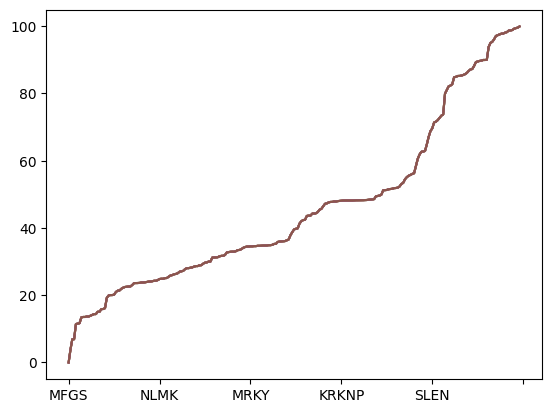

In [109]:
for df in data:
  missing_values = data[df]
  missing_values = close.isnull().sum()
  missing_percent = missing_values / len(close) * 100
  missing_percent.sort_values().plot()
plt.show()

# for df in half_data:
#   missing_values = half_data[df]
#   missing_values = close.isnull().sum()
#   missing_percent = missing_values / len(close) * 100
#   missing_percent.sort_values().plot()
# plt.show()

In [110]:
good_columns = close.ffill().interpolate(method='linear').isna().sum()[close.ffill().interpolate(method='linear').isna().sum() < 2000].index

In [111]:
close = close[good_columns].ffill().interpolate(method='linear').dropna()
open = open[good_columns].ffill().interpolate(method='linear').dropna()
high = high[good_columns].ffill().interpolate(method='linear').dropna()
low = low[good_columns].ffill().interpolate(method='linear').dropna()
volume = volume[good_columns].ffill().interpolate(method='linear').dropna()

returns = close.pct_change().dropna()

close.columns = [f'close_{col}' for col in close.columns]
open.columns = [f'open_{col}' for col in open.columns]
high.columns = [f'high_{col}' for col in high.columns]
low.columns = [f'low_{col}' for col in low.columns]
volume.columns = [f'volume_{col}' for col in volume.columns]

In [112]:
returns = close.pct_change().dropna()

In [113]:
training_data = pd.concat([
  close,
  open,
  high,
  low,
  volume
], axis=1)

In [114]:
# # Преобразуем данные в NumPy массивы для ускорения
# data_full_values = data_full.values
# target_values = data_full[target].values

# Используем списки пониманий для создания all_x и all_y
all_x = np.array([training_data[i:i+200].values for i in tqdm(range(len(training_data) - 202))])
all_y = np.array([training_data.iloc[:,0].pct_change().shift(-2).ffill().dropna()[i+200] for i in tqdm(range(len(training_data) - 202))])

  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/3832 [00:00<?, ?it/s]

C:\Users\ciell\AppData\Local\Temp\ipykernel_12320\814735216.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_y = np.array([training_data.iloc[:,0].pct_change().shift(-2).ffill().dropna()[i+200] for i in tqdm(range(len(training_data) - 202))])


In [115]:
# all_x, all_y = [], []

# for i in tqdm(range(len(training_data) - 202)):
#   try:
#     all_x.append(training_data.iloc[i:i+200].values)
#     all_y.append(training_data.iloc[:,0].pct_change().shift().ffill().dropna()[i+200])
#   except:
#     pass

# all_x = np.array(all_x)
# all_y = np.array(all_y)

In [116]:
len(all_x), len(all_y)

(3832, 3832)

In [117]:
# all_x = np.array(all_x)
# all_y = np.array(all_y)

In [118]:
# x = training_data.iloc[1:-1].values
# y = training_data.iloc[:,0].pct_change().shift().dropna().values

x, x_final = all_x[:-100], all_x[-100:]
y, y_final = all_y[:-100], all_y[-100:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [119]:
x_train.shape, y_train.shape

((2985, 200, 465), (2985,))

In [120]:
x_train = torch.Tensor(x_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.Tensor(x_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

x_final = torch.Tensor(x_final)
y_final = torch.tensor(y_final, dtype=torch.float32)

print("Shape of x_train:", x_train.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_train.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_test.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_final.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_final.shape)  # Ожидаемая форма: (3107,)

Shape of x_train: torch.Size([2985, 200, 465])
Shape of y_train: torch.Size([2985])
Shape of x_train: torch.Size([747, 200, 465])
Shape of y_train: torch.Size([747])
Shape of x_train: torch.Size([100, 200, 465])
Shape of y_train: torch.Size([100])


In [122]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Создаем dataset и dataloader
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)
final_dataset = TimeSeriesDataset(x_final, y_final)

batch_size = 64  # Выбираем подходящий размер батча

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=False)

In [123]:
# x_train = x_train.to(device)
# y_train = y_train.to(device)

# x_test = x_test.to(device)
# y_test = y_test.to(device)

# x_final = x_final.to(device)
# y_final = y_final.to(device)

### Making ML models

#### Simple single LSTM

In [124]:
# Создание простой модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Используем последнее значение из последовательности
        return out

# Гиперпараметры
input_size = x_train.shape[2]  # Количество факторов (465)
hidden_size = 50  # Размер скрытого слоя
output_size = 1  # Одно выходное значение
learning_rate = 0.0001
num_epochs = 1000

##### MSE_loss

In [129]:
# Гиперпараметры
input_size = x_train.shape[2]  # Количество факторов (465)
hidden_size = 50  # Размер скрытого слоя
output_size = 1  # Одно выходное значение
learning_rate = 0.0001
num_epochs = 1000

# Инициализация модели, потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

# Листы для хранения значений потерь
train_losses = []
val_losses = []

# Обучение модели
for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y.float())
        loss.backward() 
        optimizer.step()
    
    # Обновление шага обучения
    scheduler.step()

    # Валидация модели
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in train_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_outputs = model(val_x)
            val_loss += criterion(val_outputs.squeeze(), val_y.float()).item()
    val_loss /= len(train_loader)

    if epoch != 0 and epoch % 50 == 0:
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.5f}, Validation Loss: {val_loss:.5f}')

plt.figure(figsize=(10, 5))
plt.plot(range(50, num_epochs+1, 50), train_losses, label='Train Loss')
plt.scatter(range(50, num_epochs+1, 50), val_losses, label='Validation Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/1000], Loss: 0.00306, Validation Loss: 0.00342
Epoch [100/1000], Loss: 0.00071, Validation Loss: 0.00159
Epoch [150/1000], Loss: 0.00093, Validation Loss: 0.00131
Epoch [200/1000], Loss: 0.00017, Validation Loss: 0.00122
Epoch [250/1000], Loss: 0.00077, Validation Loss: 0.00120
Epoch [300/1000], Loss: 0.00035, Validation Loss: 0.00118


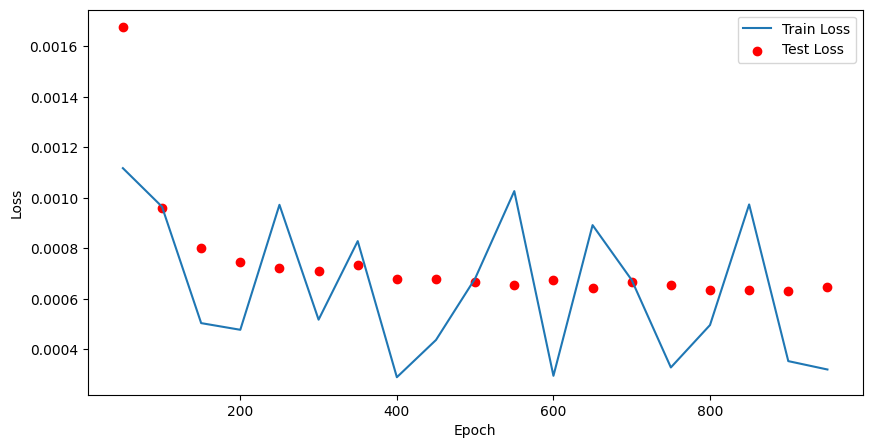

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(50, num_epochs, 50), train_losses[1:], label='Train Loss')
plt.scatter(range(50, num_epochs, 50), test_losses[1:], label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

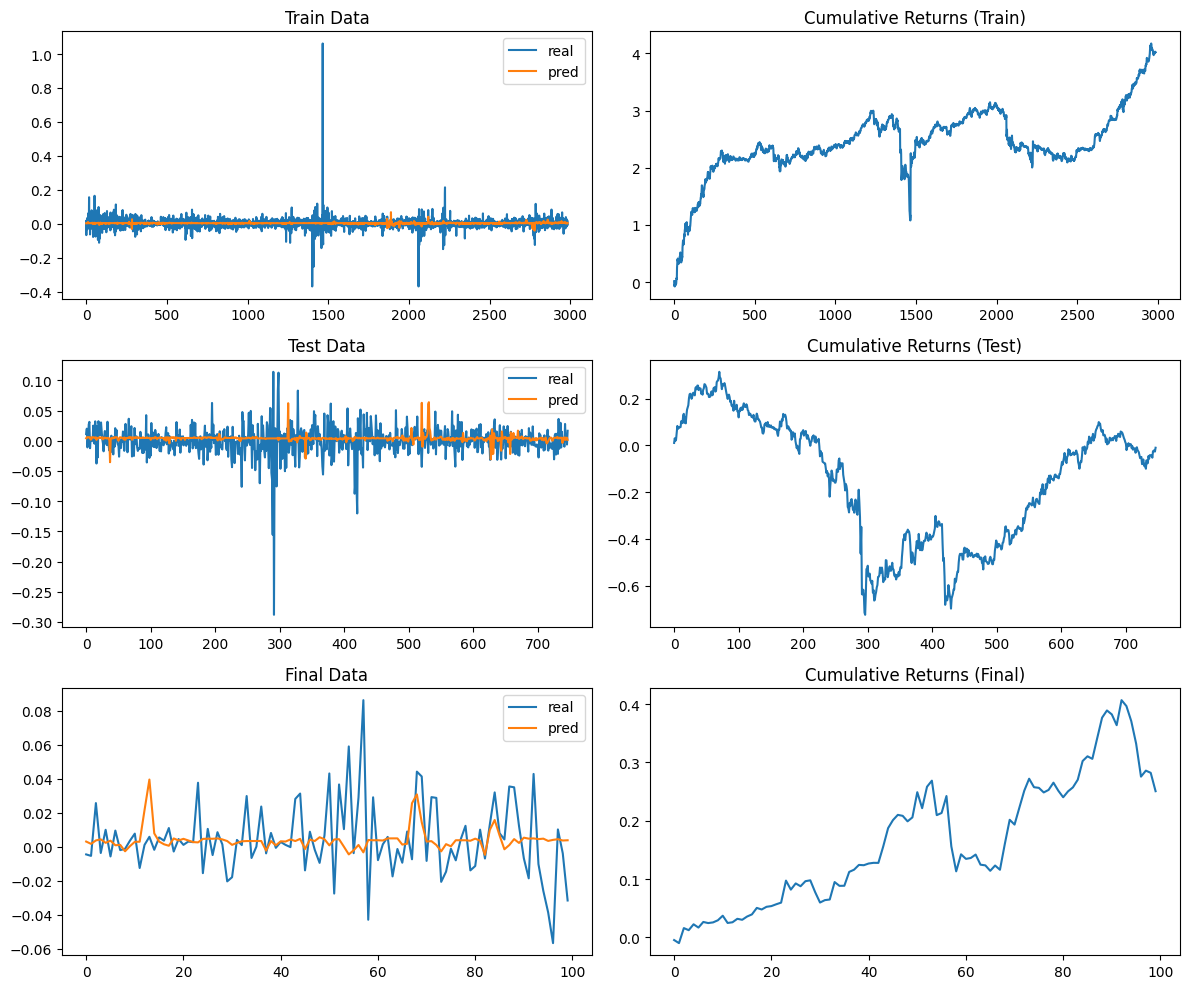

In [ ]:
# Пример кода для построения графиков в subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Первый график: реальные и предсказанные значения для обучающей выборки
model.eval()
with torch.no_grad():
    train_predictions = model(x_train.to(device)).detach().cpu().numpy()
res_train = pd.concat([pd.DataFrame(y_train.detach().cpu().numpy(), columns=['real']), 
                      pd.DataFrame(train_predictions, columns=['pred'])], axis=1)
res_train.plot(ax=axs[0, 0])
axs[0, 0].set_title('Train Data')

# Второй график: накопленная прибыль по предсказаниям для обучающей выборки
alpha_train = np.where(res_train['pred'] > 0, 1, -1)
(alpha_train * res_train['real']).cumsum().plot(ax=axs[0, 1])
axs[0, 1].set_title('Cumulative Returns (Train)')

# Третий график: реальные и предсказанные значения для тестовой выборки
model.eval()
with torch.no_grad():
    test_predictions = model(x_test.to(device)).detach().cpu().numpy()
res_test = pd.concat([pd.DataFrame(y_test.detach().cpu().numpy(), columns=['real']), 
                      pd.DataFrame(test_predictions, columns=['pred'])], axis=1)
res_test.plot(ax=axs[1, 0])
axs[1, 0].set_title('Test Data')

# Четвертый график: накопленная прибыль по предсказаниям для тестовой выборки
alpha_test = np.where(res_test['pred'] > 0, 1, -1)
(alpha_test * res_test['real']).cumsum().plot(ax=axs[1, 1])
axs[1, 1].set_title('Cumulative Returns (Test)')

# Пятый график: реальные и предсказанные значения для финальной выборки
model.eval()
with torch.no_grad():
  final_predictions = model(x_final.to(device)).detach().cpu().numpy()
res_final = pd.concat([pd.DataFrame(y_final.cpu().numpy(), columns=['real']), 
                       pd.DataFrame(final_predictions, columns=['pred'])], axis=1)
res_final.plot(ax=axs[2, 0])
axs[2, 0].set_title('Final Data')

# Шестой график: накопленная прибыль по предсказаниям для финальной выборки
alpha_final = np.where(res_final['pred'] > 0, 1, -1)
(alpha_final * res_final['real']).cumsum().plot(ax=axs[2, 1])
axs[2, 1].set_title('Cumulative Returns (Final)')

# Подписи осей и отображение графиков
plt.tight_layout()
plt.show()

##### MAE_loss

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [100/1000], Train Loss: 0.0199, Test Loss: 0.0182
Epoch [200/1000], Train Loss: 0.0184, Test Loss: 0.0169
Epoch [300/1000], Train Loss: 0.0179, Test Loss: 0.0166
Epoch [400/1000], Train Loss: 0.0177, Test Loss: 0.0164
Epoch [500/1000], Train Loss: 0.0176, Test Loss: 0.0163
Epoch [600/1000], Train Loss: 0.0175, Test Loss: 0.0162
Epoch [700/1000], Train Loss: 0.0175, Test Loss: 0.0162
Epoch [800/1000], Train Loss: 0.0175, Test Loss: 0.0162
Epoch [900/1000], Train Loss: 0.0175, Test Loss: 0.0162
Epoch [1000/1000], Train Loss: 0.0175, Test Loss: 0.0162


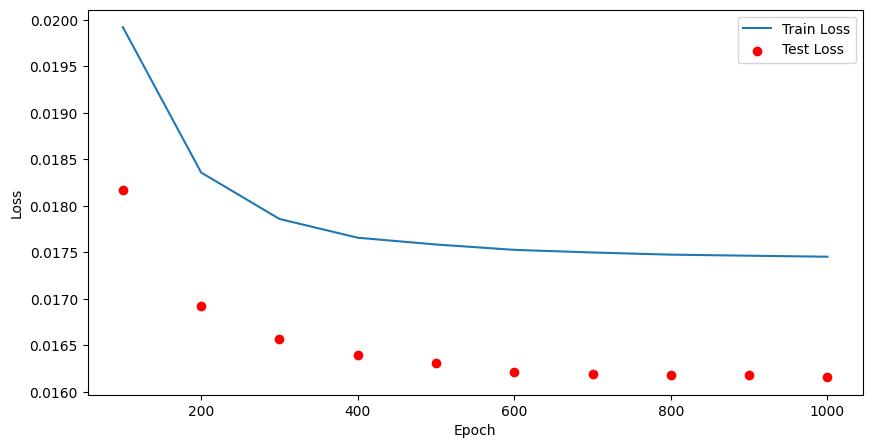

In [103]:
# Гиперпараметры
input_size = x_train.shape[2]  # Количество факторов (465)
hidden_size = 50  # Размер скрытого слоя
output_size = 1  # Одно выходное значение
learning_rate = 0.0001
num_epochs = 1000

# Инициализация модели, потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y.float())
        loss.backward() 
        optimizer.step()
        scheduler.step()

    # Валидация модели
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in test_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_outputs = model(val_x)
            val_loss += criterion(val_outputs.squeeze(), val_y.float()).item()
    val_loss /= len(test_loader)

    if epoch != 0 and epoch % 50 == 0:
        train_losses.append(loss.item())
        test_losses.append(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}, Validation Loss: {val_loss:.5f}')

plt.figure(figsize=(10, 5))
plt.plot(range(50, num_epochs+1, 50), train_losses, label='Train Loss')
plt.scatter(range(50, num_epochs+1, 50), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

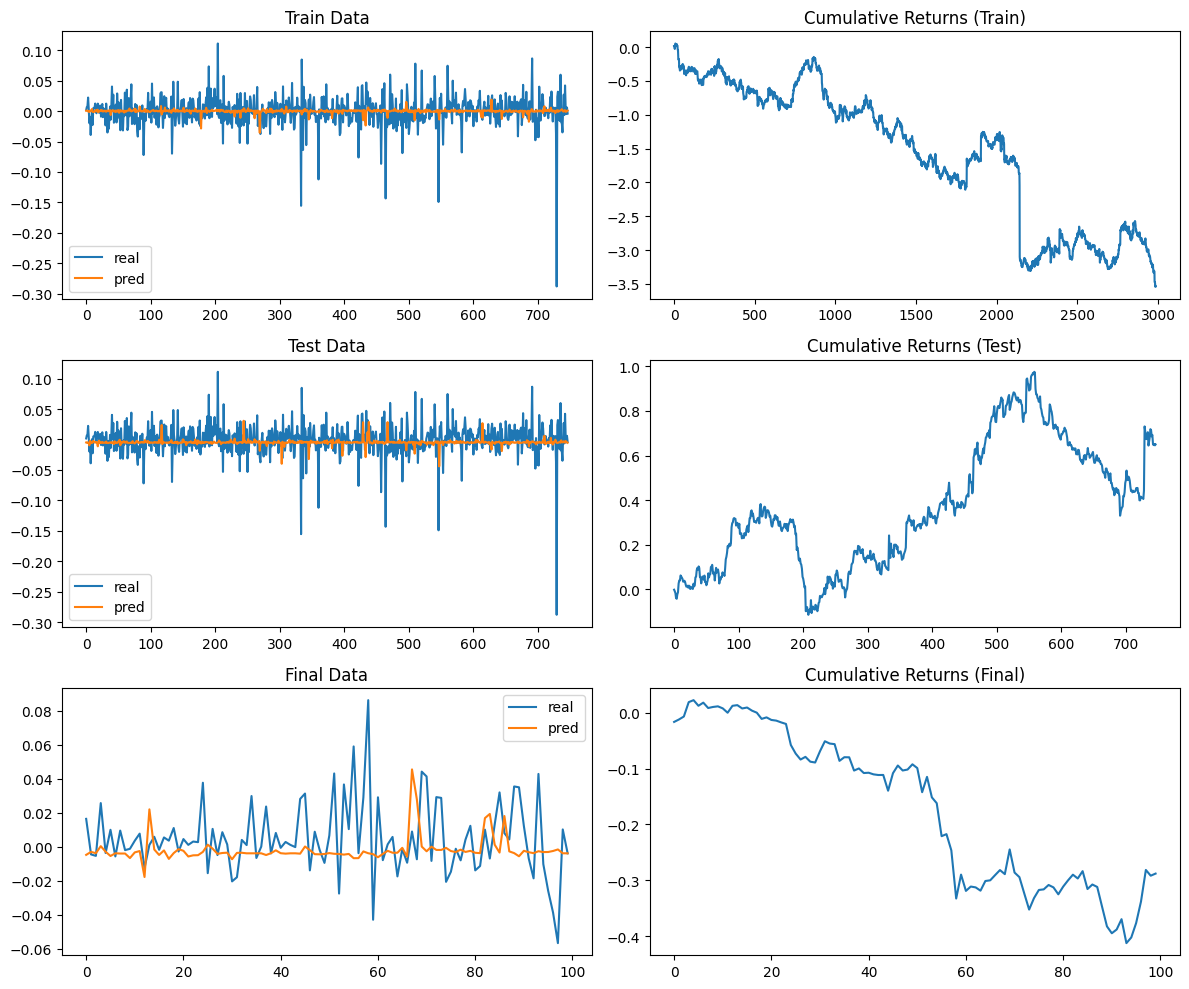

In [106]:
# Пример кода для построения графиков в subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Первый график: реальные и предсказанные значения для обучающей выборки
model.eval()
with torch.no_grad():
    train_predictions = model(x_train.to(device)).detach().cpu().numpy()
res_train = pd.concat([pd.DataFrame(y_train.detach().cpu().numpy(), columns=['real']), 
                      pd.DataFrame(train_predictions, columns=['pred'])], axis=1)
res_train.plot(ax=axs[0, 0])
axs[0, 0].set_title('Train Data')

# Второй график: накопленная прибыль по предсказаниям для обучающей выборки
alpha_train = np.where(res_train['pred'] > 0, 1, -1)
(alpha_train * res_train['real']).cumsum().plot(ax=axs[0, 1])
axs[0, 1].set_title('Cumulative Returns (Train)')

# Третий график: реальные и предсказанные значения для тестовой выборки
model.eval()
with torch.no_grad():
    test_predictions = model(x_test.to(device)).detach().cpu().numpy()
res_test = pd.concat([pd.DataFrame(y_test.detach().cpu().numpy(), columns=['real']), 
                      pd.DataFrame(test_predictions, columns=['pred'])], axis=1)
res_test.plot(ax=axs[1, 0])
axs[1, 0].set_title('Test Data')

# Четвертый график: накопленная прибыль по предсказаниям для тестовой выборки
alpha_test = np.where(res_test['pred'] > 0, 1, -1)
(alpha_test * res_test['real']).cumsum().plot(ax=axs[1, 1])
axs[1, 1].set_title('Cumulative Returns (Test)')

# Пятый график: реальные и предсказанные значения для финальной выборки
model.eval()
with torch.no_grad():
  final_predictions = model(x_final.to(device)).detach().cpu().numpy()
res_final = pd.concat([pd.DataFrame(y_final.cpu().numpy(), columns=['real']), 
                       pd.DataFrame(final_predictions, columns=['pred'])], axis=1)
res_final.plot(ax=axs[2, 0])
axs[2, 0].set_title('Final Data')

# Шестой график: накопленная прибыль по предсказаниям для финальной выборки
alpha_final = np.where(res_final['pred'] > 0, 1, -1)
(alpha_final * res_final['real']).cumsum().plot(ax=axs[2, 1])
axs[2, 1].set_title('Cumulative Returns (Final)')

# Подписи осей и отображение графиков
plt.tight_layout()
plt.show()

##### combined_loss

In [ ]:
class CombinedLoss(nn.Module):
  def __init__(self, alpha=0.5):
    super(CombinedLoss, self).__init__()
    self.alpha = alpha

  def forward(self, predictions, targets):
    mse_loss = torch.mean((predictions - targets) ** 2)
    mae_loss = torch.mean(torch.abs(predictions - targets))
    loss = self.alpha * mse_loss + (1 - self.alpha) * mae_loss
    return loss

# Использование комбинированной функции потерь
combined_loss = CombinedLoss(alpha=0.7)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [100/1000], Train Loss: 0.0094, Test Loss: 0.0080
Epoch [200/1000], Train Loss: 0.0076, Test Loss: 0.0065
Epoch [300/1000], Train Loss: 0.0067, Test Loss: 0.0058
Epoch [400/1000], Train Loss: 0.0064, Test Loss: 0.0056
Epoch [500/1000], Train Loss: 0.0063, Test Loss: 0.0055
Epoch [600/1000], Train Loss: 0.0062, Test Loss: 0.0055
Epoch [700/1000], Train Loss: 0.0062, Test Loss: 0.0056
Epoch [800/1000], Train Loss: 0.0061, Test Loss: 0.0054
Epoch [900/1000], Train Loss: 0.0061, Test Loss: 0.0054
Epoch [1000/1000], Train Loss: 0.0063, Test Loss: 0.0055


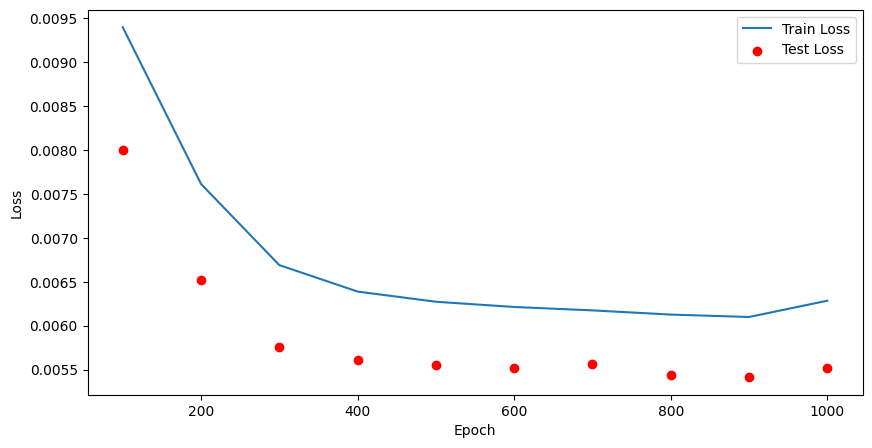

In [105]:
# Инициализация модели, функции потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    optimizer.zero_grad()
    y_pred = model(x_train).squeeze()
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_loss = loss.item()
            y_test_pred = model(x_test).squeeze()
            test_loss = criterion(y_test_pred, y_test).item()
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(100, num_epochs+1, 100), train_losses, label='Train Loss')
plt.scatter(range(100, num_epochs+1, 100), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Пример предсказания
model.eval()
with torch.no_grad():
    test_predictions = model(x_test).squeeze().cpu().numpy()
    # print("Test Predictions:", test_predictions)

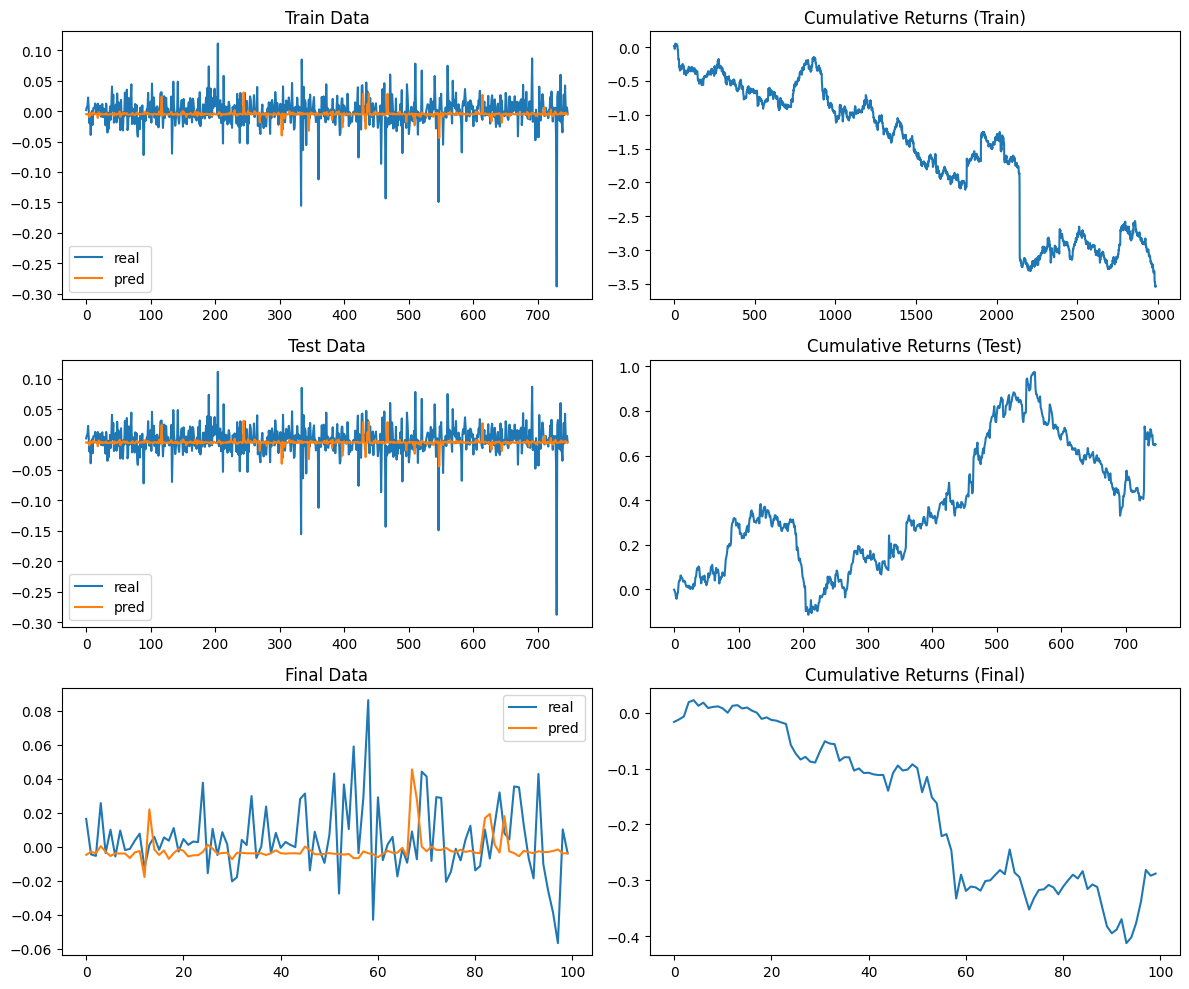

In [107]:
# Пример кода для построения графиков в subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Первый график: реальные и предсказанные значения для обучающей выборки
model.eval()
with torch.no_grad():
    train_predictions = model(x_train).squeeze().cpu().numpy()
res_train = pd.concat([pd.DataFrame(y_train.detach().cpu().numpy(), columns=['real']), 
                      pd.DataFrame(train_predictions, columns=['pred'])], axis=1)
res_test.plot(ax=axs[0, 0])
axs[0, 0].set_title('Train Data')

# Второй график: накопленная прибыль по предсказаниям для обучающей выборки
alpha_train = np.where(res_train['pred'] > 0, 1, -1)
(alpha_train * res_train['real']).cumsum().plot(ax=axs[0, 1])
axs[0, 1].set_title('Cumulative Returns (Train)')

# Третий график: реальные и предсказанные значения для тестовой выборки
res_test = pd.concat([pd.DataFrame(y_test.detach().cpu().numpy(), columns=['real']), 
                      pd.DataFrame(test_predictions, columns=['pred'])], axis=1)
res_test.plot(ax=axs[1, 0])
axs[1, 0].set_title('Test Data')

# Четвертый график: накопленная прибыль по предсказаниям для тестовой выборки
alpha_test = np.where(res_test['pred'] > 0, 1, -1)
(alpha_test * res_test['real']).cumsum().plot(ax=axs[1, 1])
axs[1, 1].set_title('Cumulative Returns (Test)')

# Пятый график: реальные и предсказанные значения для финальной выборки
model.eval()
with torch.no_grad():
  final_predictions = model(x_final).squeeze().cpu().numpy()
res_final = pd.concat([pd.DataFrame(y_final.cpu().numpy(), columns=['real']), 
                       pd.DataFrame(final_predictions, columns=['pred'])], axis=1)
res_final.plot(ax=axs[2, 0])
axs[2, 0].set_title('Final Data')

# Шестой график: накопленная прибыль по предсказаниям для финальной выборки
alpha_final = np.where(res_final['pred'] > 0, 1, -1)
(alpha_final * res_final['real']).cumsum().plot(ax=axs[2, 1])
axs[2, 1].set_title('Cumulative Returns (Final)')

# Подписи осей и отображение графиков
plt.tight_layout()
plt.show()

##### Sharpe loss

In [ ]:
class SharpeLoss(nn.Module):
  def __init__(self, alpha=0.5):
    super(SharpeLoss, self).__init__()
    # self.alpha = alpha

  def forward(self, predictions, targets):
    alpha = torch.where(predictions > 0, 1, -1)
    alpha = alpha.float().requires_grad_()
    targets = targets.float().requires_grad_()
    sharpe = (alpha * targets).sum() / (alpha * targets).std()
    loss = abs(1 / sharpe)
    return loss

class SharpeLossComissions(nn.Module):
    def __init__(self, alpha=0.5):
        super(SharpeLossComissions, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        alpha = torch.where(predictions > 0, 1, -1)
        diff = torch.diff(alpha)
        abs_diff = torch.abs(diff)
        sum_changes = torch.sum(abs_diff)
        
        sharpe = ((alpha * targets).sum() - sum_changes * 0.0004) / (alpha * targets).std()
        loss = abs(1 / sharpe)
        return loss

sharpe_loss = SharpeLoss()
sharpe_loss2 = SharpeLossComissions()

In [108]:
class CombinedLoss(nn.Module):
  def __init__(self, alpha=0.5):
    super(CombinedLoss, self).__init__()
    self.alpha = alpha

  def forward(self, predictions, targets):
    mse_loss = torch.mean((predictions - targets) ** 2)
    mae_loss = torch.mean(torch.abs(predictions - targets))
    loss = self.alpha * mse_loss + (1 - self.alpha) * mae_loss
    return loss

class SumLoss(nn.Module):
    def __init__(self):
        super(SumLoss, self).__init__()

    def forward(self, predictions, targets):
        alpha = torch.where(predictions > 0, 1.0, -1.0)
        returns = alpha * targets
        # mean_returns = returns.mean()
        # std_returns = returns.std()

        # # Избегаем деления на ноль
        # if std_returns == 0:
        #     return torch.tensor(float('inf'))

        # sharpe_ratio = mean_returns / std_returns
        loss = -returns.sum()
        return loss

class SharpeLoss(nn.Module):
    def __init__(self):
        super(SharpeLoss, self).__init__()

    def forward(self, predictions, targets):
        alpha = torch.where(predictions > 0, 1.0, -1.0)
        returns = alpha * targets
        mean_returns = returns.mean()
        std_returns = returns.std()

        # Избегаем деления на ноль
        if std_returns == 0:
            return torch.tensor(float('inf'))

        sharpe_ratio = mean_returns / std_returns
        loss = -sharpe_ratio
        return loss

In [110]:
sum_loss = SumLoss()
num_epochs = 1000
learning_rate = 0.00001

# Инициализация модели, функции потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = sum_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in tqdm(range(num_epochs)):
    model.train()

    optimizer.zero_grad()
    y_pred = model(x_train).squeeze()
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            train_loss = loss.item()
            y_test_pred = model(x_test).squeeze()
            test_loss = criterion(y_test_pred, y_test).item()
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(100, num_epochs+1, 100), train_losses, label='Train Loss')
plt.scatter(range(100, num_epochs+1, 100), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Пример предсказания
model.eval()
with torch.no_grad():
    test_predictions = model(x_test).squeeze().cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [10/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [15/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [20/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [25/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [30/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [35/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [40/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [45/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [50/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [55/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [60/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [65/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [70/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [75/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [80/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [85/1000], Train Loss: 0.7721, Test Loss: -0.0164
Epoch [90/1000], Train Loss: 0.7721, Test Loss: -

KeyboardInterrupt: 

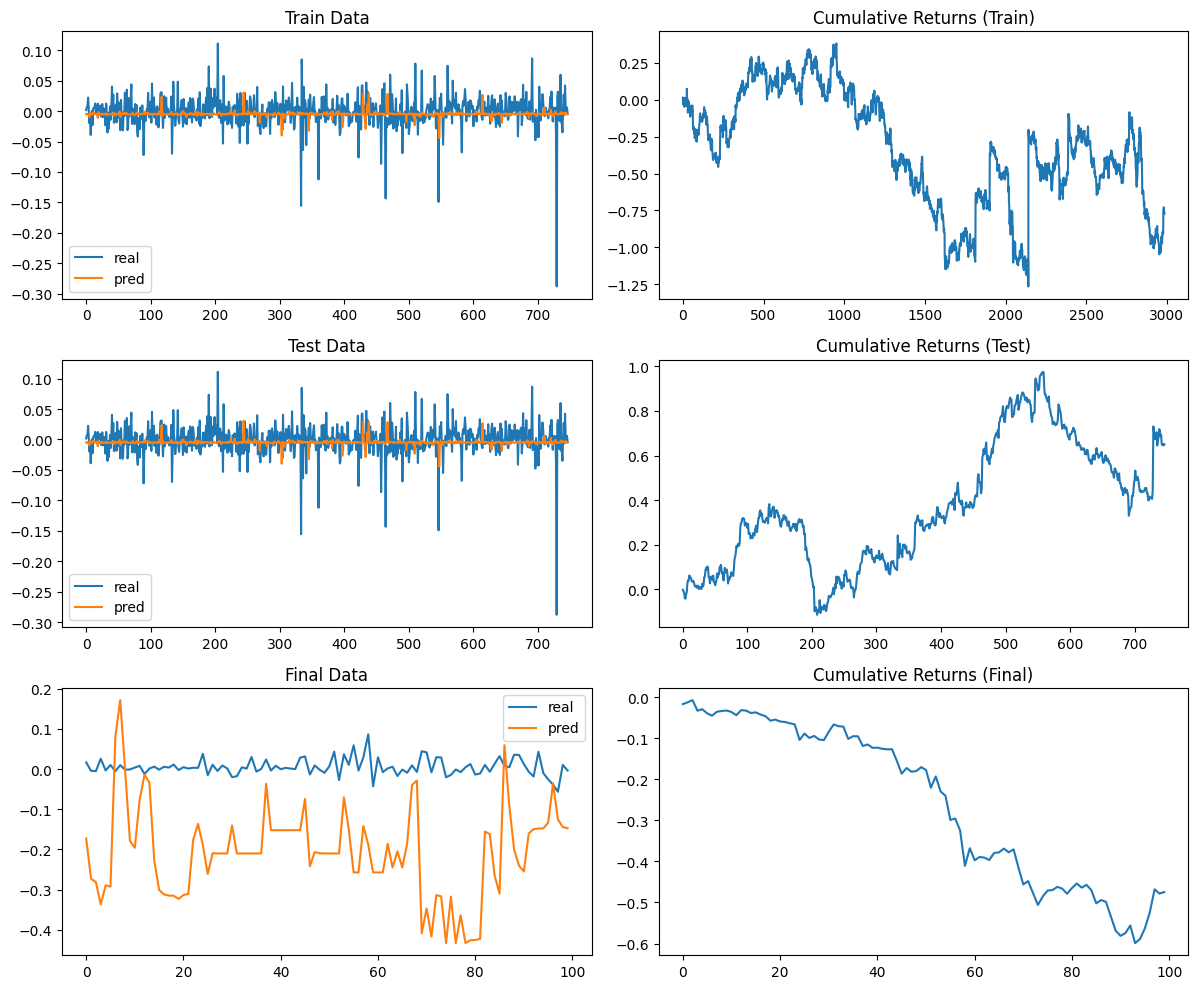

In [111]:
# Пример кода для построения графиков в subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Первый график: реальные и предсказанные значения для обучающей выборки
model.eval()
with torch.no_grad():
    train_predictions = model(x_train).squeeze().cpu().numpy()
res_train = pd.concat([pd.DataFrame(y_train.detach().cpu().numpy(), columns=['real']), 
                      pd.DataFrame(train_predictions, columns=['pred'])], axis=1)
res_test.plot(ax=axs[0, 0])
axs[0, 0].set_title('Train Data')

# Второй график: накопленная прибыль по предсказаниям для обучающей выборки
alpha_train = np.where(res_train['pred'] > 0, 1, -1)
(alpha_train * res_train['real']).cumsum().plot(ax=axs[0, 1])
axs[0, 1].set_title('Cumulative Returns (Train)')

# Третий график: реальные и предсказанные значения для тестовой выборки
res_test = pd.concat([pd.DataFrame(y_test.detach().cpu().numpy(), columns=['real']), 
                      pd.DataFrame(test_predictions, columns=['pred'])], axis=1)
res_test.plot(ax=axs[1, 0])
axs[1, 0].set_title('Test Data')

# Четвертый график: накопленная прибыль по предсказаниям для тестовой выборки
alpha_test = np.where(res_test['pred'] > 0, 1, -1)
(alpha_test * res_test['real']).cumsum().plot(ax=axs[1, 1])
axs[1, 1].set_title('Cumulative Returns (Test)')

# Пятый график: реальные и предсказанные значения для финальной выборки
model.eval()
with torch.no_grad():
  final_predictions = model(x_final).squeeze().cpu().numpy()
res_final = pd.concat([pd.DataFrame(y_final.cpu().numpy(), columns=['real']), 
                       pd.DataFrame(final_predictions, columns=['pred'])], axis=1)
res_final.plot(ax=axs[2, 0])
axs[2, 0].set_title('Final Data')

# Шестой график: накопленная прибыль по предсказаниям для финальной выборки
alpha_final = np.where(res_final['pred'] > 0, 1, -1)
(alpha_final * res_final['real']).cumsum().plot(ax=axs[2, 1])
axs[2, 1].set_title('Cumulative Returns (Final)')

# Подписи осей и отображение графиков
plt.tight_layout()
plt.show()

#### deep LSTM model

In [ ]:
class DeepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DeepLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(self.dropout(lstm_out[:, -1, :]))  # Используем последнее значение из последовательности и применяем Dropout
        return out

# Гиперпараметры
input_size = x_train.shape[2]  # Количество факторов (465)
hidden_size = 50  # Размер скрытого слоя
num_layers = 5
output_size = 1  # Одно выходное значение
learning_rate = 0.0001
num_epochs = 1000

Epoch [100/1000], Train Loss: 0.0107, Test Loss: 0.0068
Epoch [200/1000], Train Loss: 0.0083, Test Loss: 0.0068
Epoch [300/1000], Train Loss: 0.0081, Test Loss: 0.0068
Epoch [400/1000], Train Loss: 0.0080, Test Loss: 0.0068
Epoch [500/1000], Train Loss: 0.0078, Test Loss: 0.0067
Epoch [600/1000], Train Loss: 0.0077, Test Loss: 0.0068
Epoch [700/1000], Train Loss: 0.0077, Test Loss: 0.0067
Epoch [800/1000], Train Loss: 0.0075, Test Loss: 0.0067
Epoch [900/1000], Train Loss: 0.0073, Test Loss: 0.0067
Epoch [1000/1000], Train Loss: 0.0072, Test Loss: 0.0067


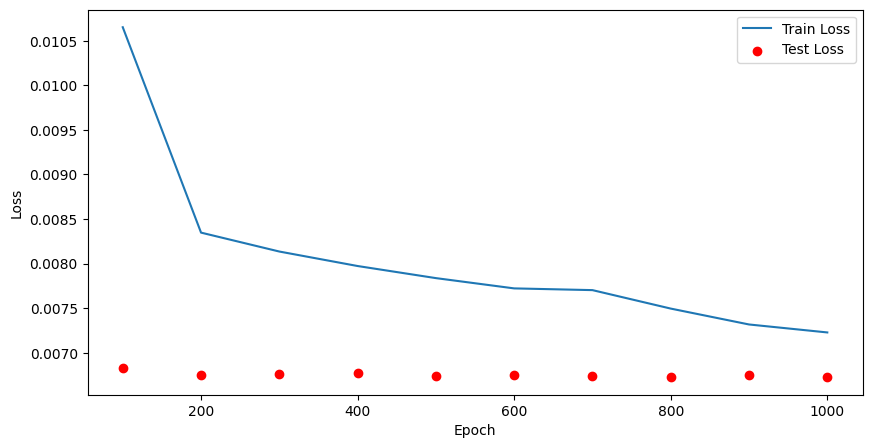

In [ ]:
# Инициализация модели, функции потерь и оптимизатора
model = DeepLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()
    y_pred = model(x_train).squeeze()
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_loss = loss.item()
            y_test_pred = model(x_test).squeeze()
            test_loss = criterion(y_test_pred, y_test).item()
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(100, num_epochs+1, 100), train_losses, label='Train Loss')
plt.scatter(range(100, num_epochs+1, 100), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Пример предсказания
model.eval()
with torch.no_grad():
    test_predictions = model(x_test).squeeze().cpu().numpy()
    # print("Test Predictions:", test_predictions)

<Axes: >

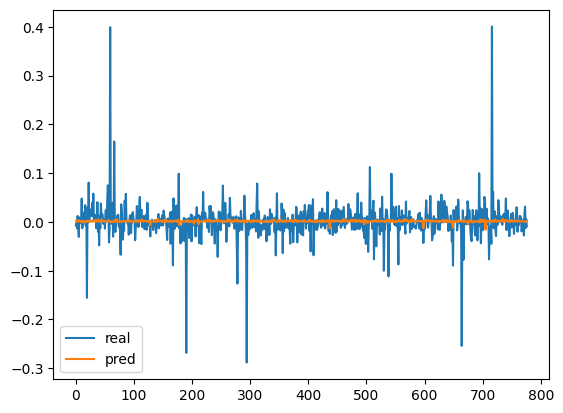

In [ ]:
res = pd.concat([pd.DataFrame(y_test.detach().cpu().numpy(), columns=['real']), pd.DataFrame(test_predictions, columns=['pred'])], axis=1)
res.plot()

<Axes: >

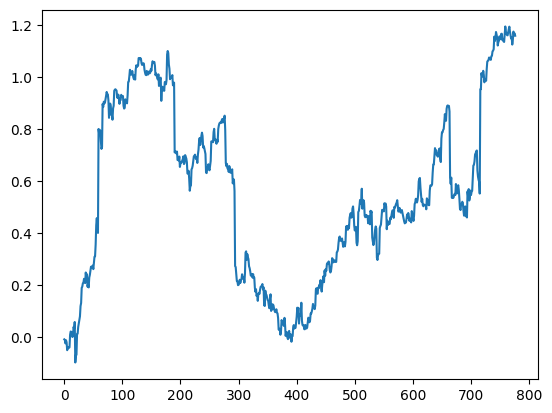

In [ ]:
alpha = np.where(res['pred'] > 0, 1, -1)
(alpha * res['real']).cumsum().plot()

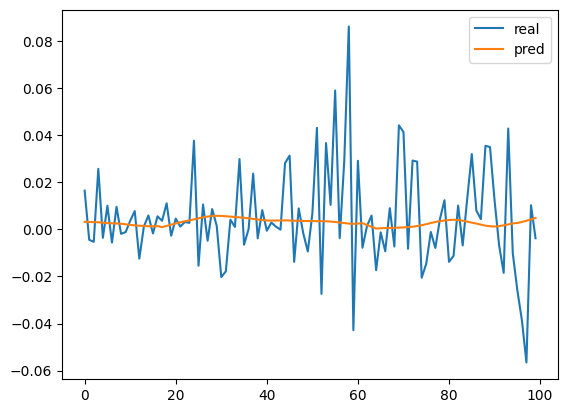

In [ ]:
model.eval()
with torch.no_grad():
  final_predictions = model(x_final).squeeze().cpu().numpy()

res = pd.concat([pd.DataFrame(y_final.cpu().numpy(), columns=['real']), pd.DataFrame(final_predictions, columns=['pred'])], axis=1)
res.plot()
plt.show()

<Axes: >

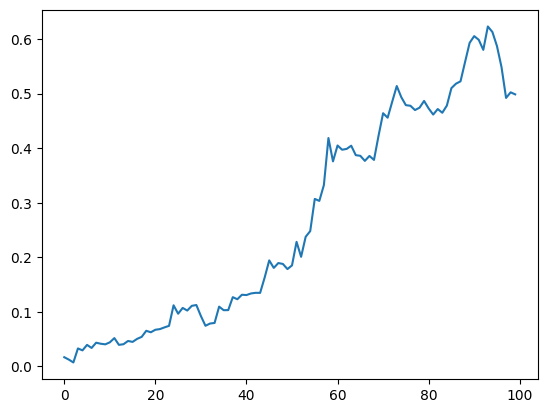

In [ ]:
alpha = np.where(res['pred'] > 0, 1, -1)
(alpha * res['real']).cumsum().plot()